#Calculating temporal variance with and without seasonal cycle

In [1]:
using CABLAB
using ImageMagick

    ./(Images.AbstractImageDirect, AbstractArray) at /Users/fgans/.julia/v0.4/Images/src/algorithms.jl:55
is ambiguous with: 
    ./(AbstractArray, Union{DataArrays.DataArray, DataArrays.PooledDataArray}) at /Users/fgans/.julia/v0.4/DataArrays/src/broadcast.jl:285.
To fix, define 
    ./(Images.AbstractImageDirect, Union{DataArrays.DataArray, DataArrays.PooledDataArray})
before the new definition.
    -(Images.AbstractImageDirect, AbstractArray) at /Users/fgans/.julia/v0.4/Images/src/algorithms.jl:35
is ambiguous with: 
    -(AbstractArray, DataArrays.DataArray) at /Users/fgans/.julia/v0.4/DataArrays/src/operators.jl:326.
To fix, define 
    -(Images.AbstractImageDirect, DataArrays.DataArray)
before the new definition.
    -(Images.AbstractImageDirect, AbstractArray) at /Users/fgans/.julia/v0.4/Images/src/algorithms.jl:35
is ambiguous with: 
    -(AbstractArray, DataArrays.AbstractDataArray) at /Users/fgans/.julia/v0.4/DataArrays/src/operators.jl:349.
To fix, define 
    -(Images.Abstr

A Cube is defined via its path and some a single variable is read into memory.

In [2]:
c             = Cube("/Volumes/BGI/scratch/DataCube/v1/brockmann-consult.de/datacube/")
cdata         = getCubeData(c,variable="SoilMoisture",latitude=(35,65), longitude=(-15,40));

Here we demonstrate how to add a user-defined function to use the DAT's capabilities. First we define the function that has the signature *xin* (input data), *xout* (output data), *maskin* (input mask), *maskout* (output mask). In this case it simply cacluates the variance of a time series. Then we call the @registerDATFunction macro, which creates a wrapper around the function and makes it applicable to a Cube object. 

In [3]:
function varianceTime{T}(xin::AbstractVector{T},xout::AbstractArray{T,0},maskin::AbstractVector,maskout::AbstractArray{UInt8,0})
  s=zero(T)
  s2=zero(T)*zero(T)
  n=0
  for i in eachindex(xin)
    if maskin[i]==CABLAB.VALID
      s+=xin[i]
      s2+=xin[i]*xin[i]
      n+=1
    end
  end
  if n>0
    m=s/n
    v=s2/n-m*m
    xout[1]=v
    maskout[1]=CABLAB.VALID
  else
    maskout[1]=CABLAB.MISSING
  end
end

@registerDATFunction varianceTime (TimeAxis,) ();

Here we call the function with our 3D data cube as its argument.

In [4]:
v1             = varianceTime(cdata);
cube_anomalies = removeMSC!(cdata,46);
v2             = varianceTime(cube_anomalies);

We get the spatial mean of the time variances

In [5]:
mv1=spatialMean(v1)
mv2=spatialMean(v2)
println("Mean variance with seasonal cycle: ", mv1)
println("Mean variance without seasonal cycle: ", mv2)

Mean variance with seasonal cycle: 0.

Plot a map of the original soil mositure data:

Interact.Slider{Int64}(Signal{Int64}(253, nactions=0),"Time Step",253,1:506,true)

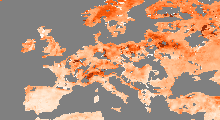

In [6]:
plotMAP(cdata)

And show the maps of variances:

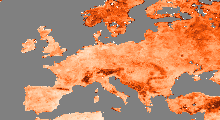

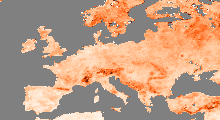

In [7]:
plotMAP(v1,dmin=0.0f0,dmax=0.01f0)
plotMAP(v2,dmin=0.0f0,dmax=0.01f0)